
# Quantum Sealed-Bid Auction: Highest Bid Finding Phase

## Introduction

In this notebook, we implement the **highest bid finding phase** of a quantum sealed-bid auction protocol using Qiskit. The protocol allows multiple bidders to determine the highest bid interval **without revealing individual bid values** and **without the need for a trusted third party**.

This implementation follows the steps described in the quantum sealed-bid auction paper, specifically focusing on the distributed phase interference and measurement process used to determine the **highest bid interval**.

### Protocol Context

- Each bidder encodes their private bid as a **one-hot vector** over \( N = 100 \) intervals.
- The goal is to determine the **leftmost 1** among all such vectors, corresponding to the highest bid.
- This is done **securely and collectively** using phase encoding over entangled quantum states.



In [28]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.visualization import plot_bloch_multivector, plot_histogram
from qiskit.quantum_info import Statevector
from qiskit.circuit.library import QFT
from qiskit_aer import AerSimulator
from qiskit import transpile
import numpy as np


 `for our example we chose N = 100, n = 4, m = 2`

In [29]:
n = 4
N = 100
m = 2
M = 2**m

## Defining function to distribute n sub-secrets

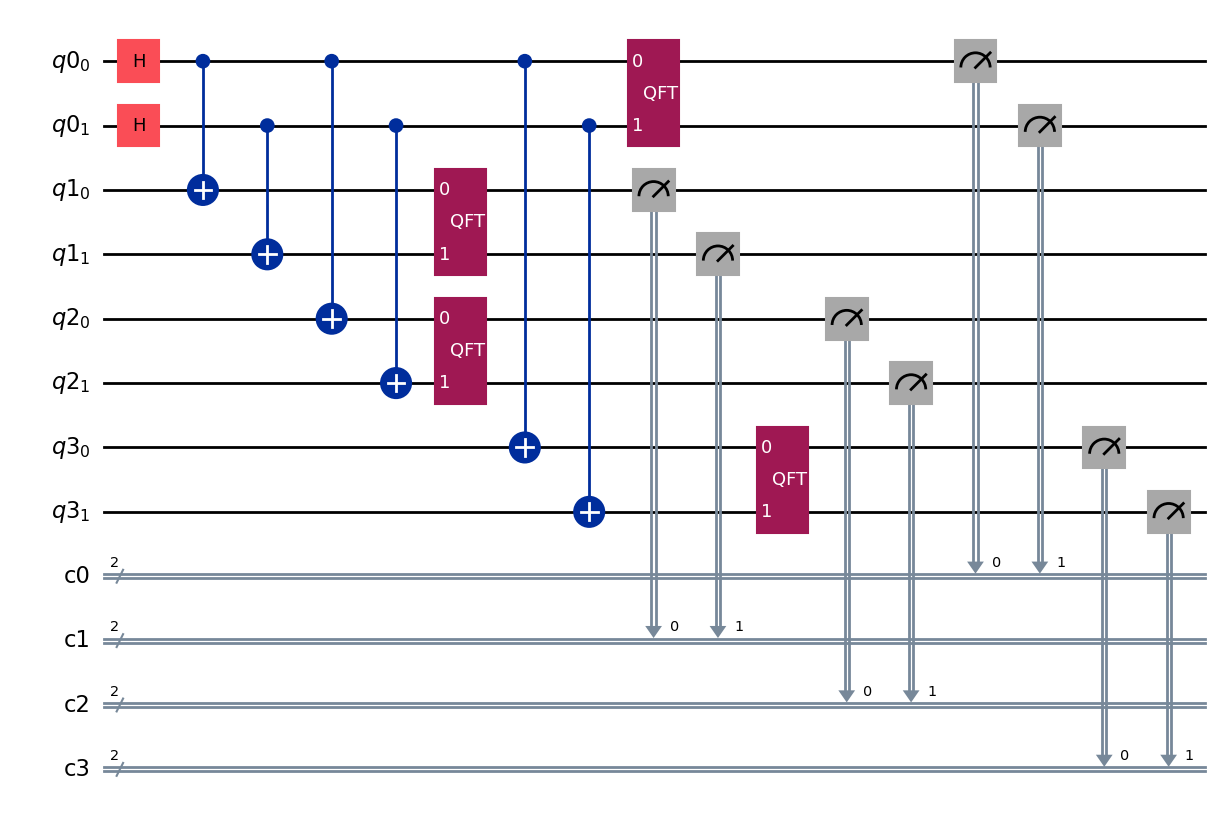

In [52]:
def phi():
    qc = QuantumCircuit()    
    qregs = []
    cregs = []
    for i in range(n):
        q = QuantumRegister(m, name=f'q{i}')
        c = ClassicalRegister(m, name=f'c{i}')
        qc.add_register(q)
        qc.add_register(c)
        qregs.append(q)
        cregs.append(c)

    qc.h(qregs[0])

    for i in range(1, n):
        for j in range(m):
            qc.cx(qregs[0][j], qregs[i][j])

    for reg in qregs:
        qc.append(QFT(num_qubits=len(reg)), reg)    
    
    for qreg, creg in zip(qregs, cregs):
        qc.measure(qreg, creg)
    # Simulate with one shot
    sim = AerSimulator()
    compiled = transpile(qc, sim)
    out = sim.run(compiled, shots=1)
    result = out.result()
    counts = result.get_counts()
    # Extract bitstring and decode per register (in reverse)
    raw_bitstring = next(iter(counts)).replace(" ", "")

    register_bitstrings = [
        raw_bitstring[i*m:(i+1)*m] for i in reversed(range(n))
    ]

    # Convert to integers mod M
    values = [int(bits, 2) % M for bits in register_bitstrings]

    return values, qc

phi()[1].draw('mpl')


In [ ]:
secrets = [[] for _ in range(n)]  # Initialize n empty lists

for _ in range(n):  # Each round
    num = phi()[0]     # num is a list of n elements in Z_M
    for i in range(n):
        secrets[i].append(num[i])  # Send each bidder's value to bidder i
print("Secrets (each list is a person’s view):", secrets)

k_values = []

for l in secrets:
    k_values.append(sum(l))

k_values    

Secrets (each list is a person’s view): [[1, 2, 0, 1], [0, 1, 0, 1], [0, 2, 2, 3], [3, 3, 2, 3]]


[4, 2, 7, 11]

In [32]:
import numpy as np

# Parameters
n = 4       # number of bidders
N = 100     # bid range
delta = 10  # bin width
d = N // delta  # dimension of hot-vector (10)

# Assign random private bid values to each bidder
np.random.seed(42)
bid_values = np.random.randint(0, N, size=n)

# Construct hot bid vectors
hot_vectors = []
for b in bid_values:
    k = (N - 1 - b) // delta  # determine interval index
    v = [0] * d
    v[k] = 1
    hot_vectors.append(v)

# Output
for i, (bid, v) in enumerate(zip(bid_values, hot_vectors), 1):
    print(f"Bidder B{i} with bid ₹{bid} → hot vector: {v}")


Bidder B1 with bid ₹51 → hot vector: [0, 0, 0, 0, 1, 0, 0, 0, 0, 0]
Bidder B2 with bid ₹92 → hot vector: [1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Bidder B3 with bid ₹14 → hot vector: [0, 0, 0, 0, 0, 0, 0, 0, 1, 0]
Bidder B4 with bid ₹71 → hot vector: [0, 0, 1, 0, 0, 0, 0, 0, 0, 0]


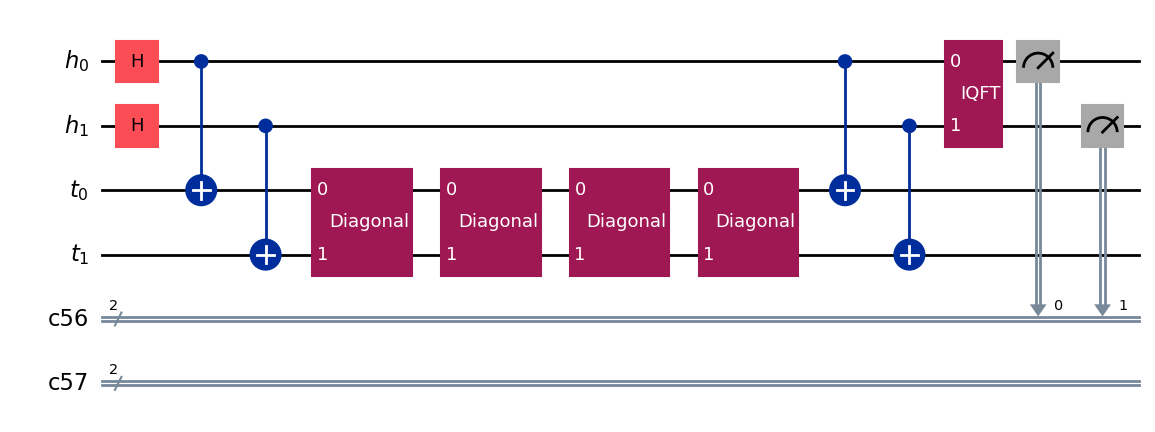

In [53]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
from qiskit.circuit.library import QFT, Diagonal
from qiskit.quantum_info import Statevector
from qiskit_aer import AerSimulator
from IPython.display import display
import numpy as np

def v(j):
    qc = QuantumCircuit()
    
    qa1 = QuantumRegister(m, 'h')
    qa2 = QuantumRegister(m, 't')
    ca1 = ClassicalRegister(m)
    ca2 = ClassicalRegister(m)
    
    qc.add_register(qa1)
    qc.add_register(qa2)
    qc.add_register(ca1)
    qc.add_register(ca2)
    
    # Step 1: Prepare entangled |φA⟩ = 1/√M ∑_x |x⟩_h |x⟩_t
    qc.h(qa1)
    for i in range(m):
        qc.cx(qa1[i], qa2[i])

    # Step 2 & 3: Apply phase shifts from all bidders
    for i in range(n):
        y = (k_values[i] + hot_vectors[i][j]) % M
        phases = [np.exp(2j * np.pi * y * x / M) for x in range(M)]
        diag_gate = Diagonal(phases)
        qc.append(diag_gate, qa2)

    # Step 4: CNOTs again (h control, t target)
    for i in range(m):
        qc.cx(qa1[i], qa2[i])

    # Step 5: Apply inverse QFT to h
    qc.append(QFT(num_qubits=m, inverse=True), qa1)
    
    # Step 6: Measure h
    qc.measure(qa1, ca1)

    sim = AerSimulator()
    compiled = transpile(qc, sim)
    result = sim.run(compiled, shots=1).result()
    count = result.get_counts()
    v = int(list(count.keys())[0][-m:]) 

    return v, qc

v(0)[1].draw('mpl')

In [55]:
for i in range(d):
    print(f'Number of bidders in the {i} interval is {v(i)[0]}')

Number of bidders in the 0 interval is 1
Number of bidders in the 1 interval is 0
Number of bidders in the 2 interval is 1
Number of bidders in the 3 interval is 0
Number of bidders in the 4 interval is 1
Number of bidders in the 5 interval is 0
Number of bidders in the 6 interval is 0
Number of bidders in the 7 interval is 0
Number of bidders in the 8 interval is 1
Number of bidders in the 9 interval is 0
